# Capstone - Financial Access in the San Francisco Bay Area

by Julian Darby

# Introduction

As a current MBA student at Berkeley Haas, an area of particular personal interest has been improving the quality of financial access, primarily through the development of financial technology (or 'fintech'). However for many Americans physical locations, such as bank branches, remain an important facet of their financial interactions. This is true even in the heart of technology: the San Francisco Bay Area.

Further, access to financial services remains uneven, and likely affected by demographic composition of communities. This provides an interesting opportunity to leverage Foursquare data to assess the current state of physical financial access in the Bay Area. While there has been a trend towards online banking as a result of the COVID-19 pandemic (American Banker, 2020) there is no certainty that this will persist following the relaxation of stay-in-place restrictions. 

Namely, a key question is whether the quality of financial services locations (as represented by their score on Foursquare) can be predicted by the demographic composition of that location. As a bank executive, I would be cautious if this turned out to be the case, as this could represent a manifestation of unequal access to the financial system. 

In this project, I have combined data from disparate sources and conducted clustering and regression techniques on the resultant data to gather insights on the distribution and characteristics of financial locations.  This information would be useful for the executives of a financial services company, for example to identify under-served communities within the Bay Area.

# Data

The data for this project has primarily been sourced from the following locations:

1. sfgov.org
2. census.gov
3. irs.gov
4. foursquare.com

The website sfgov.org contains information on the ZIP codes contained within the Bay Area, as well the geometric data required for visualisation of these ZIP codes. The website census.gov contains the US Census data. Ideally, full Census data would be used to give the maximal richness of data possible. However, the decennial US Census does not have information available at the ZIP code level, so cannot be used for this purpose. An alternative, used in this project, is the American Community Survey, which has demographic information available at the ZIP Code Tabulation Area (ZCTA) level. These do not correspond perfectly to ZIP codes in every case, but cross-walks are available to help with checking the mapping from ZCTA to ZIP code.

The Internal Revenue Service (IRS) publishes individual tax statistics, which can be accessed directly from their website. The most recent dataset is from 2017, and contains information on a ZIP code level, facilitating integration with the other data sources.

Finally, Foursquare has been used as a source of location and venue data. As the focus of this project is on financial access, the API was used to search for venues that are primarily categorised as financial (ATM, Bank, Cheque Checking Service, Credit Union, Currency Exchange, Financial or Legal Office, or Insurance Office). This data is combined with the American Community Survey to draw insights on the state of financial access in the San Francisco Bay Area.

Please refer to the methodology section below for the application of these data sources.

# Methodology

## Importing Libraries and Setting Global Options

In [441]:
# installers for packages as required:
# !pip install sodapy
# !pip install geojson

# standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.core.common import flatten

# visualisation libraries
import folium
import geojson
import json
from geojson import Feature, Point, FeatureCollection, MultiPolygon, Polygon

# machine learning libraries
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

# other libraries
import random
import requests
import os
from collections import defaultdict
from csv import writer
from operator import itemgetter
from sodapy import Socrata

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Defining the Geographic Boundaries of the Project

The data.sf.gov website has geojson data for Bay Area ZIP codes, so this code block downloads into a json.

In [2]:
url_0 = "https://data.sfgov.org/api/geospatial/u5j3-svi6?method=export&format=GeoJSON"

geojson_data = json.loads(requests.get(url_0).text)

The data.sf.gov website also has an API, which this code block queries for Bay Area ZIP code information which is then transformed into a dataframe.

In [3]:
client = Socrata("data.sfgov.org", None) # unauthenticated client (only works with public data sets)
results = client.get("f9wk-m4qb", limit = 2000) # getting Bay Area ZIP codes

sfgov_df = pd.DataFrame.from_records(results) # convert to pandas dataframe
sfgov_df = sfgov_df.astype({'zip':'int64','area':'float64'}) # change data-type of zip to integer and area to float

This code block takes the relevant columns from the `sfgov_df` dataframe and renames them. It also returns the length of the new `ZIP_df` dataframe.

In [4]:
ZIP_df = sfgov_df[['zip','po_name','area','the_geom']] # selecting three relevant columns
ZIP_df.columns = ['ZIP_code','city_name','area','geometry'] # rename columns
len(ZIP_df)

187

US census data uses ZCTA (ZIP Code Tabulation Areas) which can differ from ZIP Codes. Therefore, this code block collects a ZIP to ZCTA cross-walk file from usdmapper.org. A cross-walk is a data set that helps to reconcile these two different methodologies.

In [5]:
url_1 = "https://www.udsmapper.org/docs/zip_to_zcta_2019.xlsx"

ZIP_to_ZCTA = pd.read_excel(url_1)

ZIP_to_ZCTA = ZIP_to_ZCTA[ZIP_to_ZCTA['ZCTA'] != 'No ZCTA'] # drop 'No ZCTA' data from dataframe
ZIP_to_ZCTA = ZIP_to_ZCTA.astype({'ZCTA':'int64'}) # change data-type of ZCTA to integer

This code block looks at the Bay Area ZIP codes, and conducts a search for mis-matched ZIPs/ZCTAs from within the cross-walk data set. Important to make sure mapping is good to allow for the use of the American Community Survey data. Good mapping in this context means that the explanation "ZIP matches ZCTA" should be returned. Every other type is returned with a description of the imperfect mapping. In the Bay Area ZIP codes, only ZIP code 94035 has a poor match (spatial join to ZCTA 94043).

In [6]:
ZIP_match = 0 # initializing ZIP_match at zero
ill_defined = 0 # initializing ill_defined at zero
drop_ZIPs = [] # initalizing drop_ZIPs (i.e. ZIP Codes to drop)
dash_1 = '-' * 45 
table_format_1 = '{:<12}{:<12}{:<20s}'

print(dash_1)
print(table_format_1.format('ZIP Code','ZCTA','Join type'))
print(dash_1)

for ZIP in ZIP_df['ZIP_code']:
    if list(ZIP_to_ZCTA.loc[(ZIP_to_ZCTA['ZIP_CODE'] == ZIP),'ZCTA'])[0] != ZIP: # if ZIP Code not equal to ZTCA:
        ZCTA = list(ZIP_to_ZCTA.loc[(ZIP_to_ZCTA['ZIP_CODE'] == ZIP),'ZCTA'])[0]
        explanation = list(ZIP_to_ZCTA.loc[(ZIP_to_ZCTA['ZIP_CODE'] == ZIP),'zip_join_type'])[0]
        drop_ZIPs.append(ZIP)
        print(table_format_1.format(ZIP,ZCTA,explanation))
    
    elif list(ZIP_to_ZCTA.loc[(ZIP_to_ZCTA['ZIP_CODE'] == ZIP),'zip_join_type'])[0] == "Zip Matches ZCTA":
        # else if ZIP matches ZCTA:
        ZIP_match = ZIP_match + 1
        
    else:
        ill_defined = ill_defined + 1
        
print()
print("Matching ZIPs: %i" % ZIP_match) # matches being when ZIP Code = ZCTA
print("Ill-defined ZIPs: %i" % ill_defined) # ill-defined being anything missed by the for loop

---------------------------------------------
ZIP Code    ZCTA        Join type           
---------------------------------------------
94035       94043       Spatial join to ZCTA

Matching ZIPs: 186
Ill-defined ZIPs: 0


Then mis-matched ZIPs are dropped from dataframe (in this instance, just ZIP code 94035 is mis-matched). Mis-matched in this context means that it is not a 1:1 mapping, rather than because of an error per se.

In [7]:
bay_ZIPs = ZIP_df.set_index('ZIP_code') # set index to allow drop function to operate

for ZIP in drop_ZIPs:
    bay_ZIPs = bay_ZIPs.drop(ZIP,axis = 0)
    
bay_ZIPs.reset_index(inplace = True) # reset index after drop
bay_ZIPs.head()

,ZIP_code,city_name,area,geometry
0,94558,NAPA,1.231326e+10,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
1,94533,FAIRFIELD,9.917861e+08,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
2,95620,DIXON,7.236950e+09,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
3,95476,SONOMA,3.001414e+09,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
4,94559,NAPA,1.194302e+09,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."


Choose the boundaries of the geographic area under consideration. This can either be the full Bay Area ZIP code region, or a subset. This can be changed through changing the parameter for `search_range_custom` from `True` (custom) to `False` (full Bay Area). Setting this boundary is useful for then choosing grid squares for the Foursquare API to search over in a systematic method. This uses a custom search area, partially because certain Bay Area ZIP codes like the one corresponding to Napa have an eloganted shape, making the search area excessive large if left on full.

In [8]:
ZIP_coordinates = bay_ZIPs['geometry']

all_coordinates = []

for i, coordinates in enumerate(ZIP_coordinates):
    all_coordinates.append(ZIP_coordinates[i]['coordinates'])
    
all_coordinates = list(flatten(all_coordinates)) # flattened list of coordinates in Bay Area geometry
all_latitudes = all_coordinates[1::2] # all Bay Area latitudes in geometry
all_longitudes = all_coordinates[0::2] # all Bay Area longitudes in geometry

search_range_custom = True # choose between searching full Bay Area, or user-defined range
custom_NE_corner = [38.232169,-121.929691] # user-defined NE corner
custom_SW_corner = [37.303010,-122.522385] # user-defind SW corner

if search_range_custom == True: # if True return user-defined boundaries, otherwise full Bay Area boundaries
    max_latitude = custom_NE_corner[0]
    min_latitude = custom_SW_corner[0]
    max_longitude = custom_NE_corner[1]
    min_longitude = custom_SW_corner[1]   

else: 
    max_latitude = max(all_latitudes)
    min_latitude = min(all_latitudes)
    max_longitude = max(all_longitudes)
    min_longitude = min(all_longitudes)

This code block summarises the coordinates of the corners of the geographic boundary (and will be equivalent to the user-defined boundaries if `search_range_custom` is set to `True`).

In [9]:
def accuracy(number):
    return round(number,4)

dash_2 = '-' * 45 
table_format_2 = '{:<15}{:<15}{:<15}'

print(dash_2)
print(table_format_2.format('Corner','Latitude','Longitude'))
print(dash_2)

print(table_format_2.format('NE',accuracy(max_latitude),accuracy(max_longitude)))
print(table_format_2.format('SE',accuracy(min_latitude),accuracy(max_longitude)))
print(table_format_2.format('SW',accuracy(min_latitude),accuracy(min_longitude)))
print(table_format_2.format('NW',accuracy(max_latitude),accuracy(min_longitude)))

---------------------------------------------
Corner         Latitude       Longitude      
---------------------------------------------
NE             38.2322        -121.9297      
SE             37.303         -121.9297      
SW             37.303         -122.5224      
NW             38.2322        -122.5224      


This geographic area is then sub-divided for visualisation later and to provide smaller search areas to the Foursquare API. The level of linear precision is set here, which returns the number of sub-divisions that the overall search area will be divided into.

In [10]:
precision = 41 # set sub-divisions of overall area to do venue search over

lat_linspace = np.linspace(min_latitude,max_latitude,precision) # sets interval latitudes
long_linspace = np.linspace(min_longitude,max_longitude,precision) # sets interval longitudes

print('there are %i sub-divisions in area' % (precision -1) ** 2) # gives total number of subdivisons

there are 1600 sub-divisions in area


Next, this code block checks to see how many ZIP codes are completely contained within the search grid. Note that by definition this will be the same as the total ZIP codes if using the full Bay Area search (i.e. if `search_range_custom` is set to `False`). However, in this case we're using a custom search range, so fewer ZIP codes are entirely contained within the area.

In [11]:
ZIPs_in_region = []

for ZIP, geometry in zip(bay_ZIPs['ZIP_code'],bay_ZIPs['geometry']):
    coordinates = list(flatten(geometry['coordinates']))
    max_long, min_long = max(coordinates[0::2]), min(coordinates[0::2])
    max_lat, min_lat = max(coordinates[1::2]), min(coordinates[1::2])
    
    if max_long <= max_longitude and min_long >= min_longitude and max_lat <= max_latitude and min_lat >= min_latitude:
        ZIPs_in_region.append(ZIP)
    
    else:
        pass
    
len(ZIPs_in_region)

135

## Collecting Demographic Information from the American Community Survey

Now that the ZIP code data has been cleaned up, American Community Survery information is downloaded from data.census.gov and a dataframe `ACS_Bay_df` is created with entries corresponding to the ZIP codes of interest. As the ACS data doesn't directly contain ZIP codes (the ZCTA information is contained within `Geographic Area Name`) this information is extracted into a new column called `ZIP_code`.

In [12]:
ACS_name = 'ACSDP5Y2018.DP05_data_with_overlays_2020-05-04T030452.csv' # name of downloaded file

ACS_df = pd.read_csv(ACS_name, header = 1, low_memory = False) # skip first line of csv

ACS_column_names = list(ACS_df.columns) # create list of ACS column names
ACS_column_names_data = ACS_column_names[2:] # create list of ACS column names (data containing)

# change the data-containing columns to numeric, and replace text with NaN
ACS_df[ACS_column_names_data] = ACS_df[ACS_column_names_data].apply(pd.to_numeric, errors = 'coerce')

ACS_Bay_df = pd.DataFrame(columns = ACS_column_names) # initialize blank dataframe

for ZIP in ZIPs_in_region:
    temp_df = ACS_df[ACS_df['id'].str.contains(str(ZIP))] # look for ZIP codes from ZIPs_in_region in ACS Survey
    ACS_Bay_df = ACS_Bay_df.append(temp_df) # append to blank dataframe
    
ACS_Bay_df = ACS_Bay_df.assign(ZIP_code = np.nan)
ACS_Bay_df['ZIP_code'] = ACS_Bay_df['Geographic Area Name'].str[5:11] # extract ZCTA information as a separate column

The full dataframe from the ACS contains a large amount of information even when filtered just for the ZIP codes of interest, so this code block filters down to obtain just the columns of interest (primarily age, sex and race related). There are many different age and race grouping, so there are two `for` loops to iterate over the options.

In [13]:
column_selection = ['ZIP_code','Estimate!!SEX AND AGE!!Total population','Estimate!!Total housing units',
                   'Percent Estimate!!SEX AND AGE!!Total population!!Male',
                    'Percent Estimate!!SEX AND AGE!!Total population!!Under 5 years']

ages = [5,10,15,20,25,35,45,55,60,65,75] # start ages from ACS data age ranges

for age in ages:
    if age in [25,35,45,65,75]: # some age ranges are over a decade
        age_range = 'Percent Estimate!!SEX AND AGE!!Total population!!{} to {} years'.format(age, age + 9)
        column_selection.append(age_range)
    elif age in [5,10,15,20,55,60]: # other age ranges are over 5 years
        age_range = 'Percent Estimate!!SEX AND AGE!!Total population!!{} to {} years'.format(age, age + 4)
        column_selection.append(age_range)
    else:
        pass

column_selection.extend(['Percent Estimate!!SEX AND AGE!!Total population!!85 years and over',
                        'Estimate!!SEX AND AGE!!Total population!!Median age (years)',
                        'Percent Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)'])
    
races = ['White','Black or African American','American Indian and Alaska Native','Asian',
         'Native Hawaiian and Other Pacific Islander','Some other race']

for race in races: # iterate over races specified above
    race_name = 'Percent Estimate!!Race alone or in combination with one or more other races!!Total population!!{}'.format(race)
    column_selection.append(race_name)

This next code block iterates over the column names to change them from their original values, which are often cumbersome. For example `Estimate!!SEX AND AGE!!Total population` becomes simply `population`.

In [14]:
selected_ACS_Bay = ACS_Bay_df[column_selection] # create dataframe based on desired columns

selected_ACS_Bay = selected_ACS_Bay.rename( # rename columns as follows
    columns = {'Estimate!!SEX AND AGE!!Total population':'population',
               'Estimate!!Total housing units':'housing_units',
               'Percent Estimate!!SEX AND AGE!!Total population!!Male':'male_pct',
               'Percent Estimate!!SEX AND AGE!!Total population!!Under 5 years':'under_5_yrs_pct',
               'Percent Estimate!!SEX AND AGE!!Total population!!85 years and over':'85_and_over_pct',
               'Estimate!!SEX AND AGE!!Total population!!Median age (years)':'median_age',
               'Percent Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)':'latino_pct'
              })

for age in ages:
    if age in [25,35,45,65,75]: # some age ranges are over a decade
        selected_ACS_Bay = selected_ACS_Bay.rename(columns = {
            'Percent Estimate!!SEX AND AGE!!Total population!!{} to {} years'.format(age, age + 9):
            '{}_to_{}_yrs_pct'.format(age, age + 9)})
    
    elif age in [5,10,15,20,55,60]: # other age ranges are over 5 years
        selected_ACS_Bay = selected_ACS_Bay.rename(columns = {
            'Percent Estimate!!SEX AND AGE!!Total population!!{} to {} years'.format(age, age + 4):
            '{}_to_{}_yrs_pct'.format(age, age + 4)})

races_labels = ['white','black','native_american','asian','pacific_islander','other'] # abbreviated race names
        
for race, race_label in zip(races,races_labels):
    selected_ACS_Bay = selected_ACS_Bay.rename(columns = {
        'Percent Estimate!!Race alone or in combination with one or more other races!!Total population!!{}'.format(race):
        '{}_pct'.format(race_label)})

selected_ACS_Bay = selected_ACS_Bay.astype({'ZIP_code':'int64'}) # change data-type of zip to integer
selected_ACS_Bay.set_index('ZIP_code',inplace = True) # reset index and drop old index from dataframe
selected_ACS_Bay.head()

,population,housing_units,male_pct,under_5_yrs_pct,5_to_9_yrs_pct,10_to_14_yrs_pct,15_to_19_yrs_pct,20_to_24_yrs_pct,25_to_34_yrs_pct,35_to_44_yrs_pct,45_to_54_yrs_pct,55_to_59_yrs_pct,60_to_64_yrs_pct,65_to_74_yrs_pct,75_to_84_yrs_pct,85_and_over_pct,median_age,latino_pct,white_pct,black_pct,native_american_pct,asian_pct,pacific_islander_pct,other_pct
ZIP_code,,,,,,,,,,,,,,,,,,,,,,,,
94503,20306,5639,49.7,6.4,6.0,8.9,7.4,7.5,10.9,14.6,15.2,6.3,5.3,6.7,3.9,1.0,37.3,27.8,44.2,9.6,2.1,39.9,1.3,10.5
94591,55334,19669,48.7,5.6,4.9,5.0,6.3,7.6,13.9,12.4,13.0,7.3,7.6,10.4,4.4,1.5,40.1,20.1,41.4,19.5,1.3,35.1,1.8,9.4
94510,28262,11698,49.3,5.0,5.6,6.1,6.3,4.3,9.3,12.4,15.2,8.1,8.5,12.3,5.0,1.9,45.7,13.2,78.8,7.4,3.1,14.9,0.7,3.7
94592,1087,308,49.2,6.3,4.8,3.3,0.8,14.9,22.5,14.4,9.9,8.7,5.9,2.9,5.3,0.0,31.2,9.6,43.1,12.1,2.8,39.8,2.4,8.1
94589,30668,10097,47.3,7.3,6.1,6.1,5.9,7.2,13.9,12.7,12.5,5.6,7.5,8.8,4.3,2.0,37.4,31.1,38.9,26.3,1.6,25.7,2.5,11.7


## Collecting Income Information from the US Internal Revenue Service

The Internal Revenue Service (IRS) provides individual tax statistics at irs.gov. The most recent publication is from 2017. The file requires some cleaning due to its layout, which is started in this code block.

In [15]:
url_4 = "https://www.irs.gov/pub/irs-soi/17zp05ca.xlsx"
ca_tax = pd.read_excel(url_4, header = [0,1], skiprows = [0,1,2,5], skipfooter = 18)
# read in 2 header rows, skip rows 0, 1, 2 and 5, and skip 18 rows of footer

This code block further tidies the imported dataframe, dropping most of the columns barring `ZIP_code`, `AGI_bucket`, `number_returns` and `AGI_thousands`. Note: AGI corresponds to Adjusted Gross Income, which is defined as gross income minus adjustments to income.

In [196]:
ca_tax_short = ca_tax.iloc[:,[0,1,2,18]]
ca_tax_short.columns = ca_tax_short.columns.droplevel(level = 1)
ca_tax_short.columns = ['ZIP_code','AGI_bucket','number_returns','AGI_thousands']
ca_tax_short = ca_tax_short[ca_tax_short.ZIP_code.isin(ZIPs_in_region)]
ca_tax_short['AGI_bucket'].fillna(value = "Total", inplace = True)
ca_tax_short = ca_tax_short.astype({'ZIP_code':'int64'})

This code block defines a function to return unique values from a list.

In [197]:
def unique(from_list):
    unique_list = []
    
    for x in from_list:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

The `ca_tax_short` dataframe needs to be further transformed in order to have unique indexes. Each `ZIP_code` has multiple different AGI buckets that entries are sorted into. The `AGI_keys` list contains the unique names, while `AGI_values` contains user-defined replacements (for parsimony). `AGI_dict` is created from these two lists.

In [198]:
AGI_keys = unique(ca_tax_short['AGI_bucket'])
AGI_values = ['total','<25k','25-50k','50-75k','75-100k','100-200k','>200k']
AGI_dict = {AGI_keys[i]:AGI_values[i] for i in range(len(AGI_keys))}

The columns that will be required for the final cleaned dataframe are created here, by iterating through the keys in the `AGI_dict`. In summarise all columns: an average AGI for all returns, number of returns by AGI bracket, values of returns by AGI bracket, and percentage of returns by AGI bracket.

In [203]:
AGI_columns = ['avg_AGI']

for AGI_key in AGI_dict:
    AGI_columns.append(AGI_dict[AGI_key]+"_no")
for AGI_key in AGI_dict:
    AGI_columns.append(AGI_dict[AGI_key]+"_AGI")
for AGI_key in AGI_dict:
    AGI_columns.append(AGI_dict[AGI_key]+"_pct")

The transformed dataframe `ca_tax_T` is created here, by iterating through ZIP codes and AGI buckets and assigning values to the blank `ca_tax_T` dataframe, which is created using the columns from the prior code block and indexes from the `ZIPs_in_region` list. Certain ZIP codes are not present in the IRS data source.

In [215]:
ca_tax_T = pd.DataFrame(index = ZIPs_in_region, columns = AGI_columns)
missing_ZIPs = 0

for ZIP in ZIPs_in_region:
    
    for AGI_key in AGI_dict:
        try:
            no, AGI = list(ca_tax_short[(ca_tax_short['ZIP_code'] == ZIP) & (ca_tax_short['AGI_bucket'] == AGI_key)].iloc[0,2:4])
            ca_tax_T.at[ZIP,'{}_no'.format(AGI_dict[AGI_key])] = no
            ca_tax_T.at[ZIP,'{}_AGI'.format(AGI_dict[AGI_key])] = AGI * 1000
        except:
            missing_ZIPs += 1
    
    for AGI_key in AGI_dict:
        ca_tax_T.at[ZIP,'{}_pct'.format(AGI_dict[AGI_key])] = ca_tax_T.at[ZIP,'{}_no'.format(AGI_dict[AGI_key])] / ca_tax_T.at[ZIP,'total_no']
    
    ca_tax_T.at[ZIP,'avg_AGI'] = ca_tax_T.at[ZIP,'total_AGI'] / ca_tax_T.at[ZIP,'total_no']
        
print('there are {} missing ZIPs in the dataset'.format(int(missing_ZIPs/len(AGI_dict))))
ca_tax_T.index.name = 'ZIP_code'
ca_tax_T.head()

there are 7 missing ZIPs in the dataset


,avg_AGI,total_no,<25k_no,25-50k_no,50-75k_no,75-100k_no,100-200k_no,>200k_no,total_AGI,<25k_AGI,25-50k_AGI,50-75k_AGI,75-100k_AGI,100-200k_AGI,>200k_AGI,total_pct,<25k_pct,25-50k_pct,50-75k_pct,75-100k_pct,100-200k_pct,>200k_pct
ZIP_code,,,,,,,,,,,,,,,,,,,,,,
94503,72347,10090,2880,2230,1460,990,1920,610,729981000,36602000,82652000,89610000,85629000,266810000,168678000,1,0.285431,0.221011,0.144698,0.0981169,0.190287,0.0604559
94591,68172,27730,7500,6320,4680,3060,5020,1150,1890410000,96142000,233561000,287828000,265441000,686379000,321059000,1,0.270465,0.227912,0.16877,0.11035,0.181031,0.0414713
94510,101378,14230,3210,2290,1910,1520,3640,1660,1442612000,37515000,85194000,118179000,132214000,514879000,554631000,1,0.22558,0.160928,0.134223,0.106817,0.255798,0.116655
94592,101051,430,100,80,50,40,100,60,43452000,1240000,2973000,3064000,3695000,13688000,18792000,1,0.232558,0.186047,0.116279,0.0930233,0.232558,0.139535
94589,48729.4,14650,4880,4240,2600,1410,1410,110,713886000,65567000,155350000,159529000,121177000,182167000,30096000,1,0.333106,0.28942,0.177474,0.0962457,0.0962457,0.00750853


## Merging Together ACS and IRS data

This code block does a full outer join of the `ca_tax_T` and `selected_ACS_Bay` dataframes, on the `ZIP_code` column, to create a merged dataframe.

In [216]:
merged_df = pd.merge(ca_tax_T,selected_ACS_Bay,on = 'ZIP_code',how = 'outer')
merged_df.head()

,avg_AGI,total_no,<25k_no,25-50k_no,50-75k_no,75-100k_no,100-200k_no,>200k_no,total_AGI,<25k_AGI,25-50k_AGI,50-75k_AGI,75-100k_AGI,100-200k_AGI,>200k_AGI,total_pct,<25k_pct,25-50k_pct,50-75k_pct,75-100k_pct,100-200k_pct,>200k_pct,population,housing_units,male_pct,under_5_yrs_pct,5_to_9_yrs_pct,10_to_14_yrs_pct,15_to_19_yrs_pct,20_to_24_yrs_pct,25_to_34_yrs_pct,35_to_44_yrs_pct,45_to_54_yrs_pct,55_to_59_yrs_pct,60_to_64_yrs_pct,65_to_74_yrs_pct,75_to_84_yrs_pct,85_and_over_pct,median_age,latino_pct,white_pct,black_pct,native_american_pct,asian_pct,pacific_islander_pct,other_pct
ZIP_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94503,72347,10090,2880,2230,1460,990,1920,610,729981000,36602000,82652000,89610000,85629000,266810000,168678000,1,0.285431,0.221011,0.144698,0.0981169,0.190287,0.0604559,20306,5639,49.7,6.4,6.0,8.9,7.4,7.5,10.9,14.6,15.2,6.3,5.3,6.7,3.9,1.0,37.3,27.8,44.2,9.6,2.1,39.9,1.3,10.5
94591,68172,27730,7500,6320,4680,3060,5020,1150,1890410000,96142000,233561000,287828000,265441000,686379000,321059000,1,0.270465,0.227912,0.16877,0.11035,0.181031,0.0414713,55334,19669,48.7,5.6,4.9,5.0,6.3,7.6,13.9,12.4,13.0,7.3,7.6,10.4,4.4,1.5,40.1,20.1,41.4,19.5,1.3,35.1,1.8,9.4
94510,101378,14230,3210,2290,1910,1520,3640,1660,1442612000,37515000,85194000,118179000,132214000,514879000,554631000,1,0.22558,0.160928,0.134223,0.106817,0.255798,0.116655,28262,11698,49.3,5.0,5.6,6.1,6.3,4.3,9.3,12.4,15.2,8.1,8.5,12.3,5.0,1.9,45.7,13.2,78.8,7.4,3.1,14.9,0.7,3.7
94592,101051,430,100,80,50,40,100,60,43452000,1240000,2973000,3064000,3695000,13688000,18792000,1,0.232558,0.186047,0.116279,0.0930233,0.232558,0.139535,1087,308,49.2,6.3,4.8,3.3,0.8,14.9,22.5,14.4,9.9,8.7,5.9,2.9,5.3,0.0,31.2,9.6,43.1,12.1,2.8,39.8,2.4,8.1
94589,48729.4,14650,4880,4240,2600,1410,1410,110,713886000,65567000,155350000,159529000,121177000,182167000,30096000,1,0.333106,0.28942,0.177474,0.0962457,0.0962457,0.00750853,30668,10097,47.3,7.3,6.1,6.1,5.9,7.2,13.9,12.7,12.5,5.6,7.5,8.8,4.3,2.0,37.4,31.1,38.9,26.3,1.6,25.7,2.5,11.7


## Gathering Financial Venue Information from Foursquare

All the demographic data has been collected, so now the next step is collecting location data from the Foursquare API. Initialize Foursquare API details.

In [21]:
client_ID = '0FDZUBQYVGXXNOOVIZDJVX05AVEJB1ABJSNRV4452VDR42QJ'
client_secret = 'YPTROAKV2NYHPKI0Q5BUFTQNEBXTGYPRKLU3G24ZQBRY4TZK'
version = '20200501' # Foursquare API version

As we only want venues that can be categorised as "financial", this code block specifies a dictionary with keys corresponding to the name of relevant categories and values specifying the `category_ID`, which can be used in the Foursquare API. Note that this will also return venues with a secondary classification as financial, so we will also need to do a second stage of filtering after getting the results from Foursquare. 

In [22]:
location_categories = {'ATM':'52f2ab2ebcbc57f1066b8b56',
                       'bank':'4bf58dd8d48988d10a951735',
                       'check_cashing_service':'52f2ab2ebcbc57f1066b8b2d',
                       'credit_union':'5032850891d4c4b30a586d62',
                       'currency_exchange':'5744ccdfe4b0c0459246b4be',
                       'financial_legal_service':'503287a291d4c4b30a586d65',
                       'insurance_office':'58daa1558bbb0b01f18ec1f1'}

location_categories_list = list(location_categories.values())

location_categories_string = ','.join(location_categories_list)

This block creates the boundaries of the subdivisions required for the Foursquare search (note: only SW and NE corners required as they are rectangular polygons). It is a function of the `precision` parameter specified earlier in the code.

In [23]:
SW_corners = []
NE_corners = []

for y in range(precision-1): # iterate through latitudes, (precision - 1) times
    
    for x in range(precision-1): # iterate through longitudes, (precision - 1) times
        SW_corner = ','.join([str(lat_linspace[y]),str(long_linspace[x])]) # foursquare format (latitude, longitude)
        NE_corner = ','.join([str(lat_linspace[y+1]),str(long_linspace[x+1])]) # foursquare format (latitude, longitude)
        SW_corners.append(SW_corner)
        NE_corners.append(NE_corner)

This `for` loop collect venue information (up to the specified limit) in each grid square. For each venue it collects the `square_number`, `venue_ID`, `venue_name`, `latitude`, `longitude`, `ZIP_code`, `category_ID`, and `category_name`. Some venues will have some of this information missing, and are therefore excluded. The code block also returns the total number of venues returned from this search.

In [47]:
financial_locations = []
url_2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&intent={}&sw={}&ne={}&categoryId={}&limit={}'
    
for i, SW, NE in zip(range(len(SW_corners)),SW_corners,NE_corners):
    
    intent = 'browse'
    sw = SW
    ne = NE
    categoryID = location_categories_string
    limit = 50
    
    url_2_formatted = url_2.format(client_ID, client_secret, version, intent, sw, ne, categoryID, limit)
    request_0 = requests.get(url_2_formatted).json()
    error_code = request_0['meta']['code']
    
    if error_code == 429:
        print('max quota reached! \n')
        break
    
    else:
        try:      
            search = request_0['response']['groups'][0]['items']
    
            for v in search:
                try: 
                    financial_locations.append((
                        i,
                        v['venue']['id'],
                        v['venue']['name'], 
                        v['venue']['location']['lat'],
                        v['venue']['location']['lng'],
                        v['venue']['location']['postalCode'],
                        v['venue']['categories'][0]['id'],
                        v['venue']['categories'][0]['name']))
                
                except:
                    pass
        
        except:
            pass
        
location_col_names = ['square_number','venue_ID','venue_name','latitude','longitude',
                      'ZIP_code','category_ID','category_name']
    
locations = pd.DataFrame(financial_locations, columns = location_col_names)
len(locations)

5055

Return the number of locations per sub-division.

In [48]:
print("{} locations per sub-division on average".format(round(len(locations)/(precision - 1) ** 2,2)))

3.16 locations per sub-division on average


Some of the venues returned will not be primarily financial, so this code block now filters to return only results which have the primary category set to one of the financial types identified earlier (e.g. Bank, Insurance Office, ATM etc.). Notice that the length returned is smaller than (and at the most equal to) the length returned for the full search above.

In [49]:
primary_financial = locations[locations['category_ID'].isin(location_categories_list)] # filter for specified categories
primary_financial.set_index('venue_ID', inplace = True)
len(primary_financial)

4700

Define a function to append data to bottom of csv, used in subsequent code block.

In [50]:
def append_as_row(file_name, list_of_elem):
    
    with open(file_name, 'a', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)

Append primary_financial dataframe to csv (useful if the kernel needs to be restarted and don't want to lose previous request information).

In [51]:
filename_0 = 'primary_financial.csv'

if not(os.path.exists(filename_0)):
    primary_financial.to_csv(filename_0)

primary_financial_csv = pd.read_csv(filename_0)
existing_venues = list(primary_financial_csv['venue_ID'])

venues_to_add = set(primary_financial.index) - set(existing_venues)
    
append_as_row(filename_0,[])
    
for venue_to_add in venues_to_add:
    row_to_add = primary_financial.loc[venue_to_add]
    append_as_row(filename_0,list(flatten(([venue_to_add,list(row_to_add)]))))

Code below re-imports the dataframe as `primary_financial_static`, and checks its length. It also checks to make sure that every entry in `primary_financial` appears in `primary_financial_static`, which is what the code block above should have executed.

In [252]:
primary_financial_static = pd.read_csv(filename_0)
primary_financial_static = primary_financial_static[primary_financial_static.ZIP_code.apply(lambda x: x.isnumeric())]
primary_financial_static = primary_financial_static.astype({'ZIP_code':'int64'})
print("length: {}".format(len(primary_financial_static)))

false_checker = primary_financial.index.isin(primary_financial_static['venue_ID'])
false_count = np.size(false_checker) - np.count_nonzero(false_checker)

if false_count == 0:
    print("all current results included")
    
else:
    print("{} current result(s) missing".format(false_count))

length: 4728
1 current result(s) missing


Take a random sample of 3,000 venues (or fewer if `primary_financial_static` dataframe is shorter). For these venues we want their ratings, however as the venue details endpoint is a premium call, can only do 500 calls/day. However, a significantly larger sample is required for analysis, especially because not every `venue_ID` has a corresponding `rating`. This block of code creates a blank csv (if one doesn't exist already) and then checks how many of the `venue_IDs` in the random sample have already been done (completed_searches). It then iterates through `searches_to_complete`, appending `venue_ID` and `rating` to the csv until the maximum quota is reached.

In [166]:
random_n = 0
sample_n = min(3000,len(primary_financial_static))
filename_1 = 'ratings_samples.csv'
requests_sent = 0
error_code = 0

random.seed(random_n)
random_samples = random.sample(list(primary_financial_static['venue_ID']), sample_n)

if not(os.path.exists(filename_1)):
    with open(filename_1,"w") as file:
        pass

ratings_samples = pd.read_csv(filename_1, names = ['venue_ID','test_field'])
completed_searches = list(ratings_samples['venue_ID'])

searches_to_complete = set(random_samples) - set(completed_searches)

url_3 = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'

for search_to_complete in searches_to_complete:
    
    url_3_formatted = url_3.format(search_to_complete, client_ID, client_secret, version)
    request_1 = requests.get(url_3_formatted).json()
    error_code = request_1['meta']['code']
    
    if error_code == 429:
        print('max quota reached! \n')
        break
        
    else:
        try:
            foursquare_rating = request_1['response']['venue']['rating']

        except:
            foursquare_rating = np.nan
        
        finally:
            append_as_row(filename_1,[search_to_complete,foursquare_rating])
            requests_sent += 1

print("{} existing requests".format(len(completed_searches)))
print("{} new requests".format(requests_sent))
print("-" * 19)
print("{} total requests".format(len(completed_searches) + requests_sent))

max quota reached! 

1002 existing requests
0 new requests
-------------------
1002 total requests


Finally, this code block brings in the venue rating data as a clean dataframe called `ratings_df`, and returns the length of the dataframe.

In [223]:
ratings_df = pd.read_csv(filename_1, names = ['venue_ID','rating'])
ratings_df.dropna(inplace = True)
len(ratings_df)

187

# Results

This code block creates the `venues_by_ZIP_df` dataframe which summaries the number of venues by ZIP code and does a righ join onto the `merged_df` dataframe, which contains all of the demographic information.

In [299]:
venues_by_ZIP_df = primary_financial_static[['ZIP_code','venue_ID']].groupby(['ZIP_code']).count()
venues_by_ZIP_df = venues_by_ZIP_df.rename(columns = {'venue_ID':'venue_count'})
venues_by_ZIP_df = venues_by_ZIP_df[venues_by_ZIP_df.index.isin(ZIPs_in_region)]
venues_by_ZIP_df = pd.merge(venues_by_ZIP_df,merged_df,on = 'ZIP_code',how = 'right')
venues_by_ZIP_df['venue_count'].fillna(value = 0, inplace = True)
venues_by_ZIP_df['venues_per_thousand_pop'] = 1000 * venues_by_ZIP_df['venue_count']/venues_by_ZIP_df['population']
venues_by_ZIP_df.head()

,venue_count,avg_AGI,total_no,<25k_no,25-50k_no,50-75k_no,75-100k_no,100-200k_no,>200k_no,total_AGI,<25k_AGI,25-50k_AGI,50-75k_AGI,75-100k_AGI,100-200k_AGI,>200k_AGI,total_pct,<25k_pct,25-50k_pct,50-75k_pct,75-100k_pct,100-200k_pct,>200k_pct,population,housing_units,male_pct,under_5_yrs_pct,5_to_9_yrs_pct,10_to_14_yrs_pct,15_to_19_yrs_pct,20_to_24_yrs_pct,25_to_34_yrs_pct,35_to_44_yrs_pct,45_to_54_yrs_pct,55_to_59_yrs_pct,60_to_64_yrs_pct,65_to_74_yrs_pct,75_to_84_yrs_pct,85_and_over_pct,median_age,latino_pct,white_pct,black_pct,native_american_pct,asian_pct,pacific_islander_pct,other_pct,venues_per_thousand_pop
ZIP_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
94002,27.0,184210,13520,2410,1630,1490,1200,3090,3700,2490524000,26961000,61064000,92043000,104628000,441130000,1764698000,1,0.178254,0.120562,0.110207,0.0887574,0.22855,0.273669,27202,11015,49.9,6.2,6.9,6.3,5.6,4.7,11.5,16.2,13.8,7.3,4.9,9.1,4.8,2.7,39.8,10.9,67.6,1.8,0.6,32.7,1.1,2.6,0.992574
94005,5.0,139400,2830,510,410,380,270,630,630,394503000,6046000,15381000,23811000,23560000,91628000,234077000,1,0.180212,0.144876,0.134276,0.0954064,0.222615,0.222615,4692,1932,47.2,4.7,9.0,2.4,3.6,3.0,10.4,16.8,16.0,10.0,7.5,12.0,3.1,1.4,45.1,18.8,58.0,6.8,0.2,31.5,0.0,7.4,1.06564
94010,74.0,372777,20980,3990,2460,2220,1700,3870,6740,7820870000,42560000,91307000,138088000,147985000,552358000,6848572000,1,0.190181,0.117255,0.105815,0.0810296,0.184461,0.321258,42730,17378,47.6,5.7,6.7,7.1,6.1,3.2,11.1,14.2,16.0,6.3,7.1,9.0,5.0,2.5,42.2,10.0,66.3,2.6,0.6,31.7,0.5,5.1,1.7318
94014,28.0,62205.5,25100,7000,6930,4430,2510,3470,760,1561358000,89897000,255341000,270743000,216879000,467755000,260743000,1,0.278884,0.276096,0.176494,0.1,0.138247,0.0302789,49515,14402,50.3,4.7,4.1,4.9,4.7,7.8,19.1,12.3,12.8,6.9,7.3,8.4,5.0,2.2,38.8,33.1,25.7,4.2,1.1,55.2,1.4,17.9,0.565485
94015,56.0,70698.6,33130,8790,7860,5580,3440,5840,1620,2342244000,110892000,290845000,342705000,297395000,800980000,499427000,1,0.265318,0.237247,0.168427,0.103833,0.176275,0.0488983,64887,20842,48.8,4.1,4.5,4.1,4.9,8.1,17.2,13.7,13.2,6.9,6.2,9.9,4.9,2.5,39.4,17.5,25.9,3.9,0.6,62.7,2.0,9.6,0.863039


The `venues_df` in this code block is created by left joining the `ratings_df` dataframe onto the `primary_financial_static` dataframe, to import in available rating information to the main venue dataframe. Finally, it left joins the `merged_df` dataframe to incorporate the demographic information into the dataframe.

In [305]:
venues_df = pd.merge(primary_financial_static,ratings_df,on = 'venue_ID',how = 'left')
venues_df = pd.merge(venues_df,merged_df,on = 'ZIP_code',how = 'left')
venues_df.dropna(inplace = True)

`variables_0` defines the subset of the columns to use for the machine learning methods and visualisations.

In [487]:
variables_0 = ['avg_AGI','<25k_pct','25-50k_pct','50-75k_pct','75-100k_pct','100-200k_pct','>200k_pct',
               'population','housing_units','male_pct','under_5_yrs_pct','5_to_9_yrs_pct','10_to_14_yrs_pct',
               '15_to_19_yrs_pct','20_to_24_yrs_pct','25_to_34_yrs_pct','35_to_44_yrs_pct','45_to_54_yrs_pct',
               '55_to_59_yrs_pct','60_to_64_yrs_pct','65_to_74_yrs_pct','75_to_84_yrs_pct','85_and_over_pct',
               'median_age','latino_pct','white_pct','black_pct','native_american_pct','asian_pct',
               'pacific_islander_pct','other_pct']

For classification purposes, the rating cannot be continuous and so this code block reduces the precision of the rating to fall into semi-integer buckets.

In [436]:
venues_df['rounded_rating'] = round(venues_df['rating'] * 2) / 2

Rounding the rating also makes visualisation feasible using boxplots. The below code block shows each of the possible variables against `rounded_rating`.

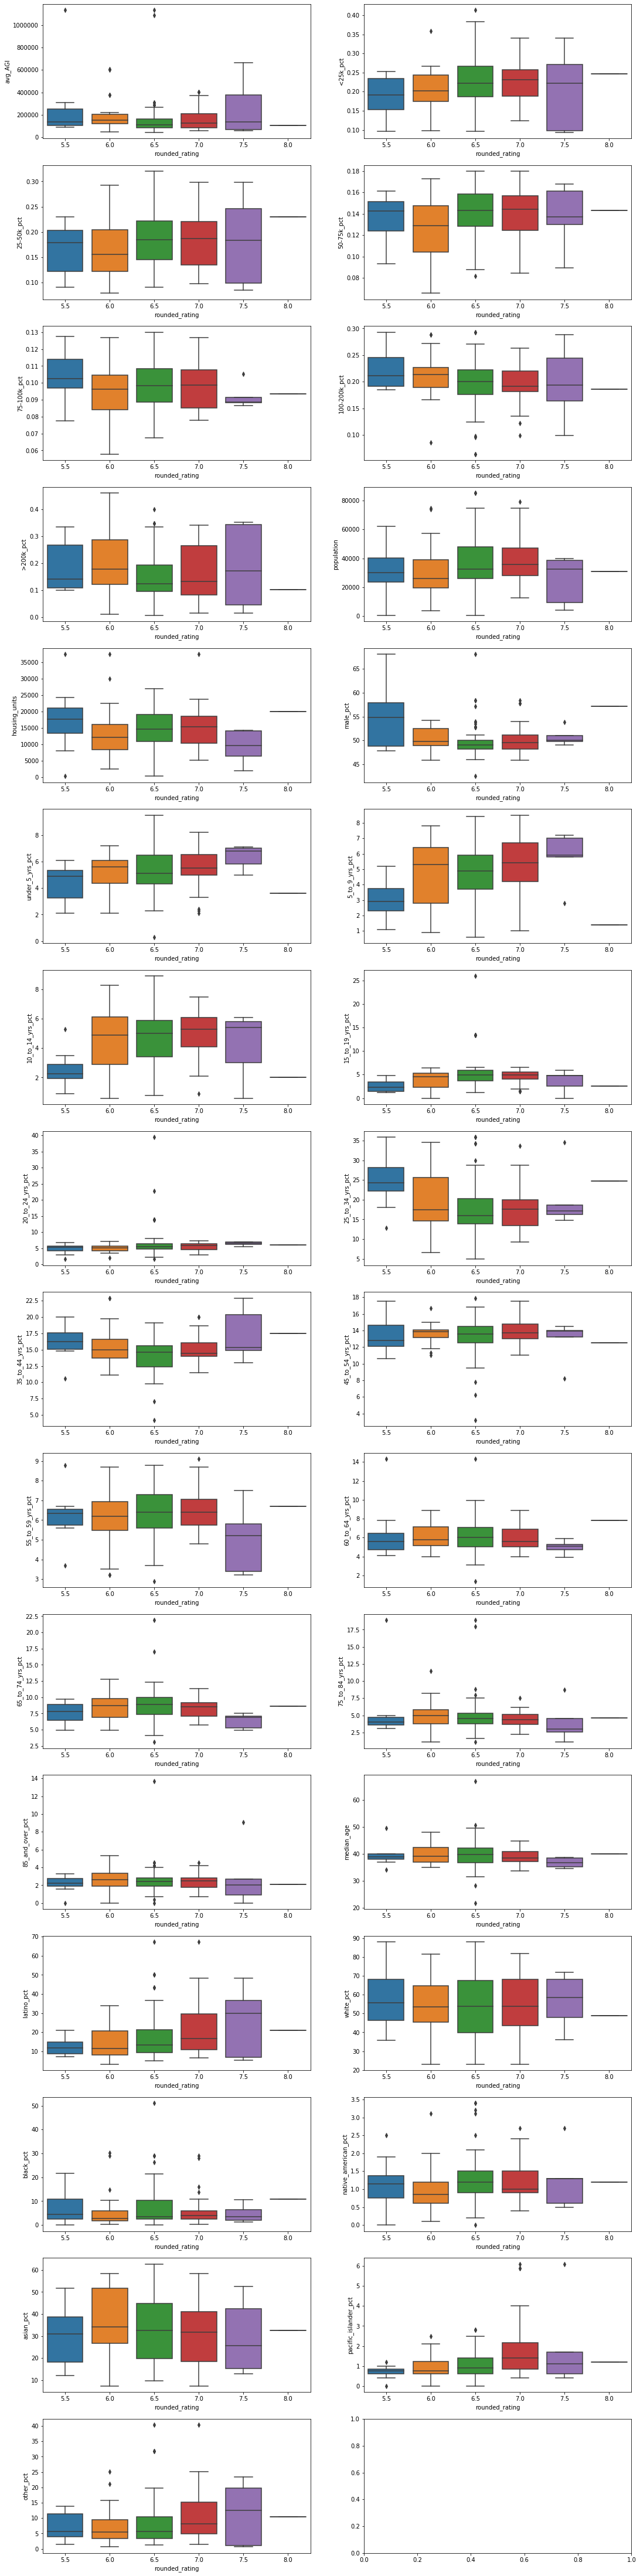

In [438]:
nrows = round(len(variables_0) / 2)
fig, axs = plt.subplots(ncols = 2, nrows = nrows, figsize = (18, nrows * 5))

for i, variable in enumerate(variables_0):

    sns.boxplot(x = venues_df['rounded_rating'], y = variable, data = venues_df, ax = axs[i // 2][i % 2])

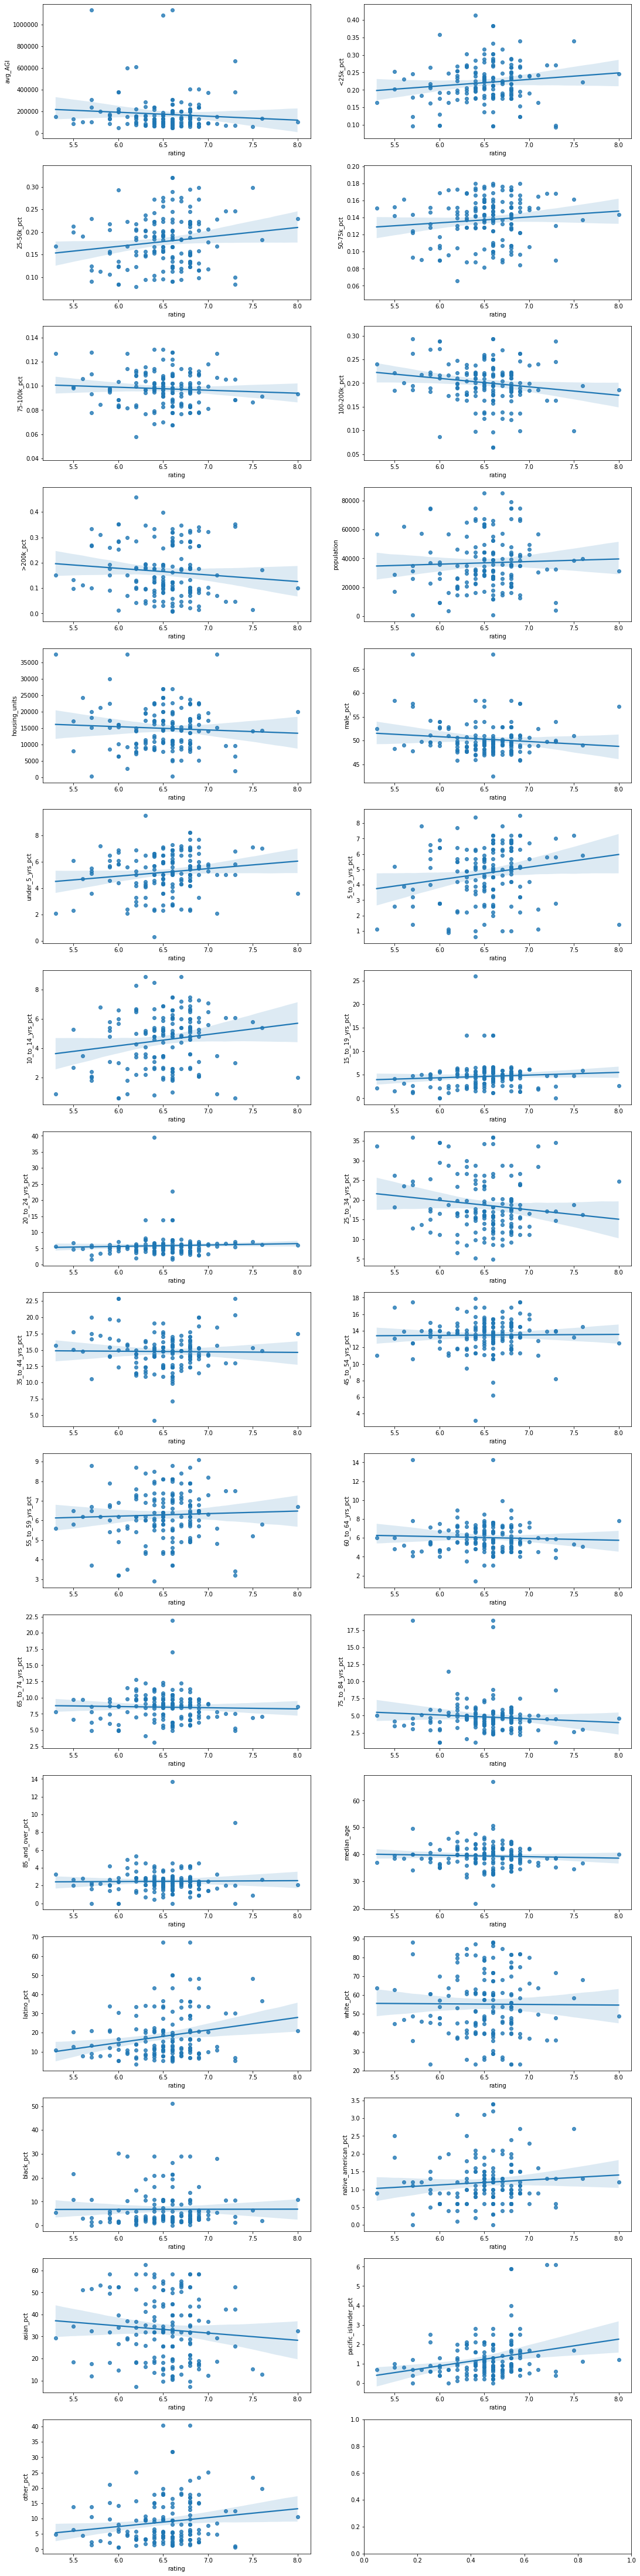

In [524]:
fig, axs = plt.subplots(ncols = 2, nrows = nrows, figsize = (18, nrows * 5))

for i, variable in enumerate(variables_0):

    sns.regplot(x = venues_df['rating'], y = variable, data = venues_df, ax = axs[i // 2][i % 2])

In [499]:
X = venues_df[variables_0]
y = venues_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [502]:
regr = MLPRegressor(solver = 'lbfgs').fit(X_train,y_train)
y_pred = regr.predict(X_test)

## K-Nearest Neighbours

The `X` and `y` variables are created based on the variables list and the `rounded_rating` column respectively. These are then split into train and test sets and the `X_train` and `X_test` variables are scaled using `StandardScaler()`.

In [508]:
X = venues_df[variables_0]
y = venues_df['rounded_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

This code block tries the K-Nearest Neighbours model on various different Ks, using the train and test sets to produce the mean and standard deviation of the accuracy of the model.

In [527]:
Ks = 10
mean_acc = np.zeros(Ks)
std_acc = np.zeros(Ks)

for n in range(1,Ks + 1):
     
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train.astype('str'))
    y_pred_KNN = KNN_model.predict(X_test)
    mean_acc[n - 1] = metrics.accuracy_score(y_test.astype('str'), y_pred_KNN)    
    std_acc[n - 1] = np.std(y_pred_KNN.astype('float') == y_test) / np.sqrt(y_pred_KNN.shape[0])

The mean accuracy, with bands representing a standard deviation, of each model under different values of `K` is displayed in this graph. 

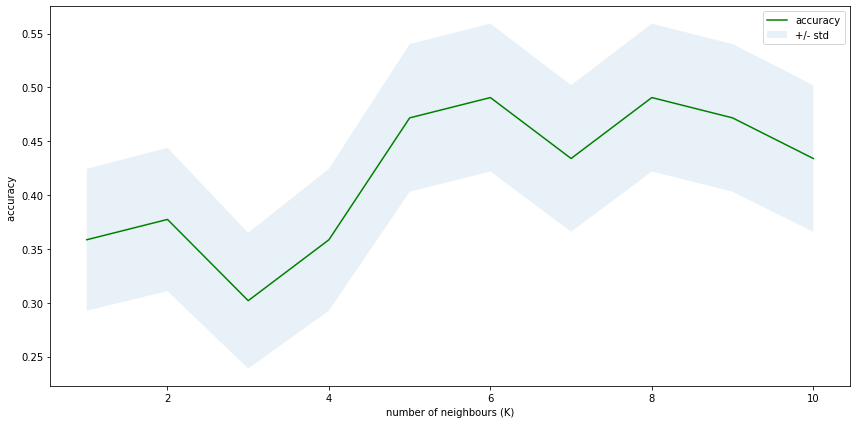

In [510]:
plt.figure(figsize = (12,6))
plt.plot(range(1,Ks + 1),mean_acc,'g')
plt.fill_between(range(1,Ks + 1),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('accuracy', '+/- std'))
plt.ylabel('accuracy ')
plt.xlabel('number of neighbours (K)')
plt.tight_layout()
plt.show()

This code block identifies the best K and its corresponding accuracy.

In [525]:
print("The best accuracy was {} with K = {}".format(round(mean_acc.max(),4), mean_acc.argmax()+1))

The best accuracy was 0.4906 with K = 6


The KNN model is then run with this value of K as the input.

In [512]:
k = mean_acc.argmax()+1
KNN_model = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train.astype('str'))

y_pred_KNN = KNN_model.predict(X_test)

The accuracy of the train and test sets is returned in this code block.

In [513]:
print("accuracy (train): ", accuracy(metrics.accuracy_score(y_train.astype('str'), KNN_model.predict(X_train))))
print("accuracy (test): ", accuracy(metrics.accuracy_score(y_test.astype('str'), y_pred_KNN)))

accuracy (train):  0.5524
accuracy (test):  0.4906


## Visualisation of Number of Results Returned by Foursquare Grid-Search

Create a feature collection that folium can then map, by iterating through the individual sub-divisions and specifying the coordinates with respect to latitude and longitude.

In [266]:
feature_list_1 = []

for y in range(precision-1): # iterate through latitudes, (precision - 1) times
    
    for x in range(precision-1): # iterate through longitudes, (precision - 1) times
        SW_coord = (long_linspace[x],lat_linspace[y])
        NW_coord = (long_linspace[x],lat_linspace[y+1])
        NE_coord = (long_linspace[x+1],lat_linspace[y+1])
        SE_coord = (long_linspace[x+1],lat_linspace[y])
        feature_coords = Feature(geometry = Polygon([[SW_coord,NW_coord,NE_coord,SE_coord,SW_coord]]))
        feature_list_1.append(feature_coords)
        
feature_collection = FeatureCollection(feature_list_1)

for i in range((precision - 1) ** 2):
    feature_collection['features'][i]['properties']['square_number'] = i

Summarise the number of samples in each square by referring to the dataframe 'primary_financial'.

In [267]:
samples = pd.DataFrame(columns = ['square_no','count'])

for i in range((precision - 1) ** 2):
    samples.loc[i] = [i,(primary_financial_static['square_number'] == i).sum()]

Plot a choropleth map with each square showing the number of samples collected from Foursquare. As expected, the greatest density occurs in population centres (e.g. San Francisco, Richmond, Oakland etc.)

In [516]:
latitude = lat_linspace[int((precision - 1) / 2)] # initialise on mid-point latitude
longitude = long_linspace[int((precision - 1) / 2)] # initialise on mid-point longitude

Bay_map = folium.Map(location=[latitude,longitude], tiles = 'OpenStreetMap', zoom_start = 9.5)

folium.Choropleth(
    geo_data = feature_collection,
    data = samples,
    columns = ['square_no','count'],
    key_on = 'feature.properties.square_number',
    fill_color = 'YlGn',
    fill_opacity = 0.7, 
    line_opacity = 0.2).add_to(Bay_map)

Bay_map

Create a feature collection for the polygons containing the ZIP codes completely contained within the search grid

In [269]:
feature_list_2 = []

for ZIP, geometry in zip(bay_ZIPs['ZIP_code'],bay_ZIPs['geometry']):

    if ZIP in ZIPs_in_region:
        
        coord_list = []
        
        for coord_pair in geometry['coordinates'][0][0]:
        
            coord_tuple = tuple(coord_pair)
            coord_list.append(coord_tuple)
    
        feature_poly = Feature(geometry = Polygon([coord_list]))
        feature_poly['properties']['ZIP_code'] = ZIP
        feature_list_2.append(feature_poly)
        
    else:
        pass
    
feature_collection_ZIPs = FeatureCollection(feature_list_2)

Choropleth map for population

In [514]:
Bay_map_2 = folium.Map(location=[latitude,longitude], tiles = 'OpenStreetMap', zoom_start = 9.5)

folium.Choropleth(
    geo_data = feature_collection_ZIPs,
    data = selected_ACS_Bay,
    columns = [selected_ACS_Bay.index,'population'],
    key_on = 'feature.properties.ZIP_code',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7, 
    line_opacity = 0.2).add_to(Bay_map_2)

Bay_map_2

Choropleth map for venue count

In [515]:
Bay_map_3 = folium.Map(location=[latitude,longitude], tiles = 'OpenStreetMap', zoom_start = 9.5)

folium.Choropleth(
    geo_data = feature_collection_ZIPs,
    data = venues_by_ZIP_df,
    columns = [venues_by_ZIP_df.index,'venue_count'],
    key_on = 'feature.properties.ZIP_code',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7, 
    line_opacity = 0.2).add_to(Bay_map_3)

Bay_map_3

# Discussion

As the scatter plots show, no single demographic variable has a strong trend against the rating of financial venues in the Bay Area. This is not unsurprising, given the complexity of the likely underlying factors impacting on venue rating. 

What is interesting however is that taking these demographic factors together in a K-Nearest Neighbor model can explain about 50% of the variation when split into test and training tests.

Further, certain ZIP codes had far more financial venues than expected, which can be seen on the “financial venues by ZIP code” slide. For example, Walnut Creek has a lot of physical venues, while San Francisco doesn’t necessarily.

# Conclusion

In conclusion, this study has shown that demographic factors can be used to explain part of the variation in rating score for financial venues in the Bay Area. Executives should therefore be careful to ensure that demographics then are not affecting the quality of service experienced by residents in different ZIP codes. A follow-on piece of analysis would be determining whether the link between demographics and rating is causal, which is beyond the scope of this exercise.

# Sources

https://www.americanbanker.com/news/digital-banking-is-surging-during-the-pandemic-will-it-last

https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx

https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi

https://www.udsmapper.org/zcta-crosswalk.cfm

https://data.census.gov/cedsci/table?q=All%20ZCTAs%20in%20United%20States&tid=ACSDP5Y2018.DP05&hidePreview=true&vintage=2018&layer=VT_2018_860_00_PY_D1&cid=DP05_0001E&g=0100000US.860000

https://developer.foursquare.com/docs/build-with-foursquare/categories/
